# CCM counter example classification

The following example shows that CCM may not be better than STD

In [114]:
import sys
import numpy as np
from graphviz import Digraph, Source
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sympy import Matrix, simplify, symbols
from sympy.solvers.solveset import linsolve

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.flow import Graph, Node, sample_graph
from lib.data import SubColumn
from lib.models import MLP, CCM_res, SubColumnNet
from lib.train import train_step_standard, train_step_xyc, train
from lib.regularization import EYE
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c, bootstrap

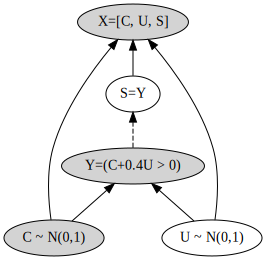

In [86]:
dot = Digraph()

dot.node('Y', 'Y=(C+0.4U > 0)', style='filled', fillcolor='lightgray')
dot.node('C', 'C ~ N(0,1)', style='filled', fillcolor='lightgray')
dot.node('U', 'U ~ N(0,1)')
dot.node('S', 'S=Y')
dot.node('X', 'X=[C, U, S]', style='filled', fillcolor='lightgray')

dot.edges(['UY', 'CY', 'UX', 'CX', 'SX'])
dot.edge('Y', 'S', style='dashed')

dot.graph_attr['rankdir'] = 'BT'
dot.render('figures/counter_example2')
dot

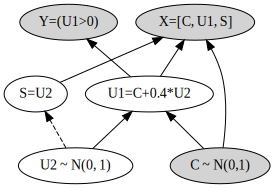

In [2]:
dot = Digraph()

dot.node('X', 'X=[C, U1, S]', style='filled', fillcolor='lightgray')
dot.node('C', 'C ~ N(0,1)', style='filled', fillcolor='lightgray')
dot.node('Y', 'Y=(U1>0)', style='filled', fillcolor='lightgray')
dot.node('U', 'U1=C+0.4*U2')
dot.node('Z', 'U2 ~ N(0, 1)')
dot.node('S', 'S=U2')
dot.edges(['UY', 'CU', 'ZU', 'UX', 'SX', 'CX'])
dot.edge('Z', 'S', style='dashed')

dot.graph_attr['rankdir'] = 'BT'
dot.render('figures/counter_example')
dot

This case is interesting b/c the problem is linear and C for sure is relevant for predicting Y.

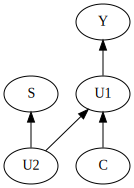

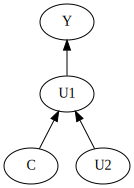

          C        U2         S        U1  Y
0 -0.328478 -0.841422 -0.841422 -0.665047  0
1  1.267562  1.132415  1.132415  1.720528  1
2  1.533854 -0.236301 -0.236301  1.439334  1
3  0.792378  1.696971  1.696971  1.471166  1
4 -0.622260  0.200247  0.200247 -0.542161  0
5 -1.614264 -1.172477 -1.172477 -2.083255  0
6  0.734232  0.294200  0.294200  0.851912  1
7 -0.823884 -1.139418 -1.139418 -1.279651  0
8 -0.656765  2.702627  2.702627  0.424286  1
9 -0.241632  0.412994  0.412994 -0.076434  0


,C,U2,S,U1,Y
0,0.759493,-0.570859,-1.924442,0.531149,1
1,-0.189001,0.100121,-1.135029,-0.148952,0
2,-0.954209,-0.616063,-0.343164,-1.200635,0
3,-0.197812,-0.618013,1.559217,-0.445017,0
4,0.818991,0.311362,0.436508,0.943536,1
5,0.608871,0.748237,-2.523885,0.908166,1
6,0.136659,-1.076185,-0.761160,-0.293815,0
7,0.236512,-0.021207,-0.464127,0.228029,1
8,1.264529,0.881607,0.198293,1.617172,1
9,-0.341486,-1.002171,-1.060884,-0.742355,0


In [3]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    c = Node('C')
    u2 = Node('U2')
    s = Node('S', lambda u2: u2, [u2])
    u1 = Node('U1', lambda c, u2: c + 0.4 * u2, [c, u2])
    y  = Node('Y', lambda u1: (u1 > 0).astype(int),
              [u1], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([c, u1, u2, s, y])   
    return graph

def build_graph_deploy():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    c = Node('C')
    u2 = Node('U2')
    s = Node('S')
    u1 = Node('U1', lambda c, u2: c + 0.4 * u2, [c, u2])
    y  = Node('Y', lambda u1: (u1 > 0).astype(int),
              [u1], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([c, u1, u2, s, y])   
    return graph

graph = build_graph() # the causal graph
graph.draw()
graph_deploy = build_graph_deploy()
graph_deploy.draw()
n = 10
print(sample_graph(graph, {'C': np.random.randn(n), 'U2': np.random.randn(n)})[['C', 'U2', 'S', 'U1', 'Y']])
sample_graph(graph_deploy, {'C': np.random.randn(n), 'U2': np.random.randn(n), 'S': np.random.randn(n)})[['C', 'U2', 'S', 'U1', 'Y']]

In [4]:
np.sqrt(1.16), 1.4**2

(1.0770329614269007, 1.9599999999999997)

In [162]:
n = 100000
bs = 100
wd = 1e-4

XYC = sample_graph(graph, {'C': np.random.randn(n), 'U2': np.random.randn(n)})[['C', 'U2', 'S', 'U1', 'Y']]
XYC_te = sample_graph(graph, {'C': np.random.randn(n), 'U2': np.random.randn(n)})[['C', 'U2', 'S', 'U1', 'Y']]
# XYC_deploy = sample_graph(graph_deploy, {'C': np.random.randn(n), 'U2': np.random.randn(n), 'S': np.random.randn(n)})[['C', 'U2', 'S', 'U1', 'Y']]
XYC_deploy = sample_graph(graph_deploy, {'C': np.random.randn(n), 'U2': np.random.randn(n), 'S': np.zeros(n)})[['C', 'U2', 'S', 'U1', 'Y']]

def get_X_Y_C(XYC):
    X = np.array(XYC[['C', 'U1', 'S']])
    Y = np.array(XYC[['Y']]).ravel()
    C = np.array(XYC[['C']])
    return torch.from_numpy(X).float(), torch.from_numpy(Y).long(), torch.from_numpy(C).float()

X, Y, C = get_X_Y_C(XYC)
d = X.shape[1]
X_te, Y_te, C_te = get_X_Y_C(XYC_te)
X_de, Y_de, C_de = get_X_Y_C(XYC_deploy)
r = torch.zeros(d) # concept mask
r[0] = 1

# accuracy
acc_criterion = lambda o, y: (o.argmax(1) == y).float()

# dataset
loader_xy = DataLoader(TensorDataset(X, Y), batch_size=bs, shuffle=True) # regular dataset
loader_xy_te = DataLoader(TensorDataset(X_te, Y_te), batch_size=bs, shuffle=False) # regular dataset
loader_xy_de = DataLoader(TensorDataset(X_de, Y_de), batch_size=bs, shuffle=False) # regular dataset

train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 837.32it/s]


epoch   2: loss 1.176e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 820.42it/s]


epoch   5: loss 6.448e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 873.49it/s]


epoch   8: loss 4.192e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 868.16it/s]


epoch  11: loss 3.013e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 868.66it/s]


epoch  14: loss 2.336e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 746.13it/s]


epoch  17: loss 1.909e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 756.78it/s]


epoch  20: loss 1.617e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 830.98it/s]


epoch  23: loss 1.406e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 773.51it/s]


epoch  26: loss 1.246e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 894.95it/s]


epoch  29: loss 1.120e-02


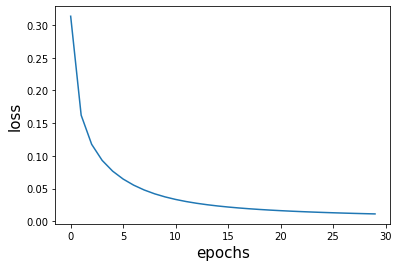

In [141]:
def standard_model(loader_xy, d, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    # regular model
    net = MLP([d, 2])
    
    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)
    return net

n_epochs = 30
STD = standard_model(loader_xy, d, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [142]:
# ['C', 'U1=C+0.4*U2', 'S=U2']
STD.classifier[0].weight[1] - STD.classifier[0].weight[0]

tensor([14.2131, 41.7581,  5.7048], grad_fn=<SubBackward0>)

train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 552.41it/s]


epoch   2: loss 1.577e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 584.67it/s]


epoch   5: loss 9.994e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 701.86it/s]


epoch   8: loss 8.310e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 628.21it/s]


epoch  11: loss 7.784e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 557.76it/s]


epoch  14: loss 7.398e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 698.57it/s]


epoch  17: loss 7.017e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 620.59it/s]


epoch  20: loss 6.668e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 619.29it/s]


epoch  23: loss 6.463e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 698.61it/s]


epoch  26: loss 6.368e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 633.35it/s]


epoch  29: loss 6.317e-02


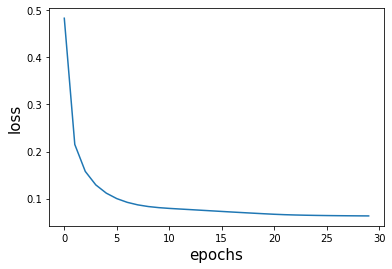

In [144]:
def CCM(loader_xy, r, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    # regular model
    net = MLP([len(r), 2])

    # train
    # criterion = lambda o_y, y: F.cross_entropy(o_y, y) + 0.01 * (net.classifier[0].weight[1] - net.classifier[0].weight[0])[1:].abs().sum()
    criterion = lambda o_y, y: F.cross_entropy(o_y, y) + 0.0009 * EYE(r, (net.classifier[0].weight[1] - net.classifier[0].weight[0])[1:].abs().sum())
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=criterion)
    if plot: plot_log(log)
    return net

n_epochs = 30
ccm = CCM(loader_xy, r, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [145]:
# ['C', 'U1=C+0.4*U2', 'S=U2']
ccm.classifier[0].weight[1] - ccm.classifier[0].weight[0]

tensor([1.5106e+01, 1.0541e-03, 5.8937e+00], grad_fn=<SubBackward0>)

train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 798.33it/s]


epoch   0: loss 6.079e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 787.18it/s]


epoch   1: loss 3.639e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 780.04it/s]


epoch   2: loss 3.049e-01


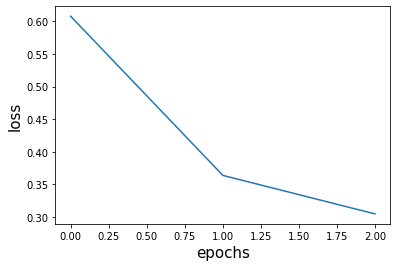

In [221]:
def CBM(loader_xy, r, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    net = nn.Sequential(SubColumnNet(r.bool()), MLP([int(sum(r).item()), 2]))

    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)
    return net

n_epochs = 3
cbm = CBM(loader_xy, r, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [222]:
cbm[1].classifier[0].weight[1] - cbm[1].classifier[0].weight[0], [p for p in cbm[1].classifier.parameters()]

(tensor([2.7642], grad_fn=<SubBackward0>),
 [Parameter containing:
  tensor([[-1.1617],
          [ 1.6024]], requires_grad=True),
  Parameter containing:
  tensor([0.3705, 0.3989], requires_grad=True)])

In [224]:
cbm[1].classifier[0].weight[1] - cbm[1].classifier[0].weight[0], [p for p in cbm[1].classifier.parameters()]

(tensor([2.7642], grad_fn=<SubBackward0>),
 [Parameter containing:
  tensor([[-1.1617],
          [ 1.6024]], requires_grad=True),
  Parameter containing:
  tensor([0.3705, 0.3989], requires_grad=True)])

freeze


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 592.32it/s]


epoch   0: loss 1.633e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 658.04it/s]


epoch   1: loss 9.338e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 650.07it/s]


epoch   2: loss 7.111e-02


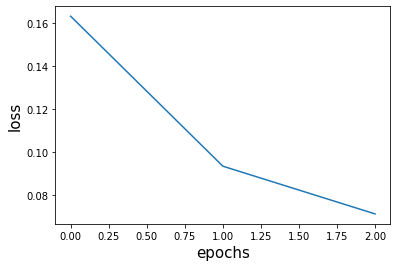

In [223]:
def Res(loader_xy, cbm, d, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    net = MLP([d, 2])    
    net = CCM_res(cbm, net)

    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    # opt = optim.SGD(net.parameters(), lr=0.01, weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)
    return net

n_epochs = 3
res = Res(loader_xy, cbm, d, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [166]:
res.net2.classifier[0].weight[1] - res.net2.classifier[0].weight[0]

tensor([11.8475, 15.8938,  4.6980], grad_fn=<SubBackward0>)

In [148]:
print('task acc after training: {:.1f}%'.format(test(res, loader_xy_te, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(ccm, loader_xy_te, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(cbm, loader_xy_te, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(STD, loader_xy_te, acc_criterion) * 100))

test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 894.81it/s]


task acc after training: 100.0%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1233.37it/s]


task acc after training: 99.7%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1138.29it/s]


task acc after training: 14.1%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1364.85it/s]

task acc after training: 100.0%


In [167]:
print('task acc after training: {:.1f}%'.format(test(res, loader_xy_de, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(ccm, loader_xy_de, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(cbm, loader_xy_de, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(STD, loader_xy_de, acc_criterion) * 100))

test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 956.96it/s]


task acc after training: 95.1%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1024.01it/s]


task acc after training: 87.9%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1027.27it/s]


task acc after training: 20.7%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1398.30it/s]

task acc after training: 97.1%


# Regression

$$min_\theta \mathbb{E}_{(x=[c,u_1,s,1], y)} (y-\theta^T x)^2$$

where $u_1 = c + a s$ with $a \in \mathbb{R}$.

taking derivative on both sides and set to $0$ simplies to 

In [51]:
# unregularized solution
c, c2, s, s2, a = symbols('E(C) E(C^2) E(S) E(S^2) a')
u1 = c + a * s
y = u1

A = Matrix([[c2, c2 + a*c*s, c*s, c], [c2 + a*c*s, c2 + a*a*s2 + 2*a*c*s, c*s + a*s2, u1], [s*c, c*s + a*s2, s2, s], [c, u1, s, 1]])
b = Matrix([[c2 + a*c*s], [c2 + a*a*s2 + 2*a*c*s], [c*s + a*s2], [y]])

result = linsolve((A, b))
result # [C, U1, S, 1]

FiniteSet((tau0/a, 1 - tau0/a, tau0, 0))

In [52]:
A

Matrix([
[              E(C^2),                 E(C)*E(S)*a + E(C^2),            E(C)*E(S),          E(C)],
[E(C)*E(S)*a + E(C^2), 2*E(C)*E(S)*a + E(C^2) + E(S^2)*a**2, E(C)*E(S) + E(S^2)*a, E(C) + E(S)*a],
[           E(C)*E(S),                 E(C)*E(S) + E(S^2)*a,               E(S^2),          E(S)],
[                E(C),                        E(C) + E(S)*a,                 E(S),             1]])

In [56]:
# unregularized CCM res solution
c, c2, s, s2, a = symbols('E(C) E(C^2) E(S) E(S^2) a')
u1 = c + a * s
y = u1

A = Matrix([[c2, c2 + a*c*s, c*s, c], [c2 + a*c*s, c2 + a*a*s2 + 2*a*c*s, c*s + a*s2, u1], [s*c, c*s + a*s2, s2, s], [c, u1, s, 1]])
b = Matrix([[a*c*s], [a*a*s2 + a*c*s], [a*s2], [a*s]])
result = linsolve((A, b))
result # [C, U1, S, 1]; CCM res solution should add back 1 to the first entry

FiniteSet((-1 + tau0/a, 1 - tau0/a, tau0, 0))

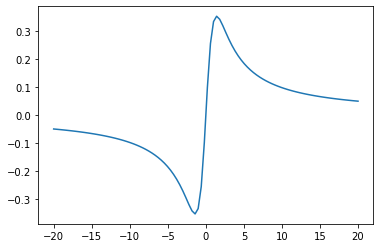

In [60]:
import matplotlib.pyplot as plt
a = np.linspace(-20, 20, 100)
plt.plot(a, 2*a / (2*a**2+4))

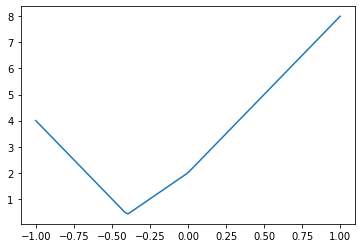

In [85]:
# l1 reg on ccm res
a = -0.4
t = np.linspace(-1, 1, 100)
plt.plot(t, np.abs(-1 + t/a) + np.abs(1-t/a) + np.abs(t))

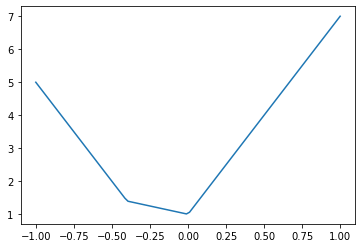

In [83]:
# l1 reg
a = -0.4
t = np.linspace(-1, 1, 100)
plt.plot(t, np.abs(t/a) + np.abs(1-t/a) + np.abs(t))

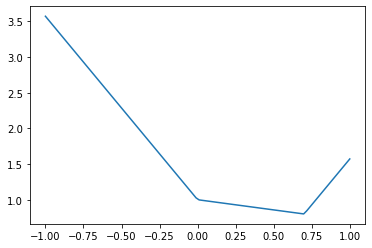

In [84]:
# weighte l1 reg
a = 0.7
b = 0.1
t = np.linspace(-1, 1, 100)
plt.plot(t, b * np.abs(t/a) + np.abs(1-t/a) + np.abs(t))

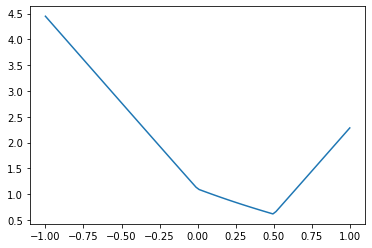

In [82]:
# EYE
a = 0.5
b = 0.1
t = np.linspace(-1, 1, 100)
plt.plot(t, b * np.sqrt((t/a)**2 + (np.abs(1-t/a) + np.abs(t))**2) + np.abs(1-t/a) + np.abs(t))